In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

# Utility functions

In [3]:
import numpy as np

import pytransform3d.rotations as pr
from pytransform3d.plot_utils import plot_vector

# constants

origin = np.array([0, 0, 0])

# basis vectors
x = np.array([1, 0, 0])
y = np.array([0, 1, 0])
z = np.array([0, 0, 1])

# basis vectors as homogeneous coordinates
xh = np.array([1, 0, 0, 1])
yh = np.array([0, 1, 0, 1])
zh = np.array([0, 0, 1, 1])

# helper functions
def get_rot_x(angle):
    '''
    transformation matrix that rotates a point about the standard X axis
    '''
    Rx = np.zeros(shape=(3, 3))
    Rx[0, 0] = 1
    Rx[1, 1] = np.cos(angle)
    Rx[1, 2] = -np.sin(angle)
    Rx[2, 1] = np.sin(angle)
    Rx[2, 2] = np.cos(angle)
    
    return Rx

def get_rot_y(angle):
    '''
    transformation matrix that rotates a point about the standard Y axis
    '''
    Ry = np.zeros(shape=(3, 3))
    Ry[0, 0] = np.cos(angle)
    Ry[0, 2] = -np.sin(angle)
    Ry[2, 0] = np.sin(angle)
    Ry[2, 2] = np.cos(angle)
    Ry[1, 1] = 1
    
    return Ry

def get_rot_z(angle):
    '''
    transformation matrix that rotates a point about the standard Z axis
    '''
    Rz = np.zeros(shape=(3, 3))
    Rz[0, 0] = np.cos(angle)
    Rz[0, 1] = -np.sin(angle)
    Rz[1, 0] = np.sin(angle)
    Rz[1, 1] = np.cos(angle)
    Rz[2, 2] = 1
    
    return Rz

def create_rotation_transformation_matrix(angles, order):
    '''
    Create a matrix that rotates a vector through the given angles in the given order
    wrt the standard global axes (extrinsic rotation)
    Note: The rotation is carried out anti-clockwise in a left handed axial system
    
    Parameters
    -----------
    angles - list
        list of angles in radians
    order - string
        the order in which to rotate
        
    Returns
    --------
    net - np.ndarray, shape - (3, 3)
        The transformation matrix which carries out the given rotations
    '''
    fn_mapping = {'x': get_rot_x, 'y': get_rot_y, 'z': get_rot_z}
    net = np.identity(3)
    for angle, axis in list(zip(angles, order))[::-1]:
        if fn_mapping.get(axis) is None:
            raise ValueError("Invalid axis")
        R = fn_mapping.get(axis)
        net = np.matmul(net, R(angle))
        
    return net

def create_translation_matrix(offset):
    '''
    Create a transformation matrix that translates a vetor by the given offset
    
    Parameters
    -----------
    offset - np.ndarray, shape - (3,)
        The translation offset
    
    Returns
    ----------
    T - np.ndarray, shape - (4, 4)
        The translation matrix
    '''
    T = np.identity(4)
    T[:3, 3] = offset
    return T

make_line = lambda u, v: np.vstack((u, v)).T

def create_rotation_change_of_basis_matrix(transformation_matrix):
    '''
    Creates a rotation change of basis matrix
    '''
  
    xt = transformation_matrix.T @ x.reshape(3, 1)
    yt = transformation_matrix.T @ y.reshape(3, 1)
    zt = transformation_matrix.T @ z.reshape(3, 1)
    
    return np.hstack((xt, yt, zt))

def create_image_grid(f, img_size):
    '''
    Create an image grid of the given size parallel to the XY plane
    at a distance f from the camera center (origin)
    '''
    h, w = img_size
    xx, yy = np.meshgrid(range(-(h // 2), w // 2 + 1), range(-(h // 2), w // 2 + 1))
    Z = np.ones(shape=img_size) * f

    return xx, yy, Z

def convert_grid_to_homogeneous(xx, yy, Z, img_size):
    '''
    Extract coordinates from a grid and convert them to homogeneous coordinates
    '''
    h, w = img_size
    pi = np.ones(shape=(4, h*w))
    c = 0
    for i in range(h):
        for j in range(w):
            x = xx[i, j]
            y = yy[i, j]
            z = Z[i, j]
            point = np.array([x, y, z])
            pi[:3, c] = point
            c += 1
    return pi

def convert_homogeneous_to_grid(pts, img_size):
    '''
    Convert a set of homogeneous points to a grid
    '''
    xxt = pts[0, :].reshape(img_size)
    yyt = pts[1, :].reshape(img_size)
    Zt = pts[2, :].reshape(img_size)

    return xxt, yyt, Zt

def create_same_plane_points(n_points, xlim, ylim, elevation):
    '''
    Create points that lie on the same plane within the given limits at the given elevation
    '''
    x = np.linspace(xlim[0], xlim[1], n_points)
    y = np.linspace(ylim[0], ylim[1], n_points)
    xxs, yys = np.meshgrid(x, y)
    zzs = elevation * np.ones(shape=(n_points, n_points))
    same_plane_points = np.ones(shape=(3, n_points * n_points))
    c = 0
    for i in range(n_points):
        for j in range(n_points):
            xs = xxs[i, j]
            ys = yys[i, j]
            zs = zzs[i, j]
            same_plane_points[:, c] = np.array([xs, ys, zs])
            c += 1
    return same_plane_points
    
def compute_intrinsic_parameter_matrix(f, s, a, cx, cy):
    K = np.identity(3)
    K[0, 0] = f
    K[0, 1] = s
    K[0, 2] = cx
    K[1, 1] = a * f
    K[1, 2] = cy
    
    return K
    
def compute_image_projection(points, K):
    '''
    Compute projection of points onto the image plane
    
    Parameters
    -----------
    points - np.ndarray, shape - (3, n_points)
        points we want to project onto the image plane
        the points should be represented in the camera coordinate system
    K - np.ndarray, shape - (3, 3)
        camera intrinsic matrix
        
    Returns
    -------
    points_i - np.ndarray, shape - (2, n_points)
        the projected points on the image
    '''
        
    h_points_i = K @ points
    
    h_points_i[0, :] = h_points_i[0, :] / h_points_i[2, :]
    h_points_i[1, :] = h_points_i[1, :] / h_points_i[2, :]

    points_i = h_points_i[:2, :]    
    
    return points_i
    
def generate_random_points(n_points, xlim, ylim, zlim):
    '''
    Generate random points in the given limits
    '''
    x = np.random.randint(xlim[0], xlim[1], size=n_points)
    y = np.random.randint(ylim[0], ylim[1], size=n_points)
    z = np.random.randint(zlim[0], zlim[1], size=n_points)
    
    return np.vstack((x, y, z))
    
def compute_coordniates_wrt_camera(world_points, E, is_homogeneous=False):
    '''
    Performs a change of basis operation from the world coordinate system
    to the camera coordinate system
    
    Parameters
    ------------
    world_points - np.ndarray, shape - (3, n_points) or (4, n_points)
             points in the world coordinate system
    E - np.ndarray, shape - (3, 4)
        the camera extrinsic matrix
    is_homogeneous - boolean
        whether the coordinates are represented in their homogeneous form
        if False, an extra dimension will  be added for computation
        
    Returns
    ----------
    points_c - np.ndarray, shape - (3, n_points)
             points in the camera coordinate system
    '''
    if not is_homogeneous:
        # convert to homogeneous coordinates
        points_h = np.vstack((world_points, np.ones(world_points.shape[1])))
        
    points_c = E @ points_h
    return points_c

def create_algebraic_matrix(world_points, projections):
    '''
    Create the algebraic matrix A for camera calibration
    
    Parameters
    -----------
    world points - np.ndarray, shape - (3, n_points)
        points in the world coordinate system
        
    projections - np.ndarray, shape - (3, n_points)
        projections of the above points in the image
        
    Returns
    ----------
    A - np.ndarray, shape - (2 * n_points, 12)
        the algebraic matrix used for camera calibration
    '''
    
    assert world_points.shape[1] == projections.shape[1]
    n_points = world_points.shape[1]
    A = np.ones(shape=(2*n_points, 12))
    
    c = 0
    
    for i in range(n_points):
        
        w = world_points[:, i]
        p = projections[:, i]
        
        X, Y, Z = w
        u, v = p
        rows = np.zeros(shape=(2, 12))
        
        rows[0, 0], rows[0, 1], rows[0, 2], rows[0, 3] = X, Y, Z, 1
        rows[0, 8], rows[0, 9], rows[0, 10], rows[0, 11] = -u * X, -u * Y, -u * Z, -u

        rows[1, 4], rows[1, 5], rows[1, 6], rows[1, 7] = X, Y, Z, 1
        rows[1, 8], rows[1, 9], rows[1, 10], rows[1, 11] = -v * X, -v * Y, -v * Z, -v
        
        A[c:c+2, :] = rows
        c += 2
        
    return A

def compute_world2img_projection(world_points, M, is_homogeneous=False):
    '''
    Given a set of points in the world and the overall camera matrix,
    compute the projection of world points onto the image
    
    Parameters
    -----------
    world_points - np.ndarray, shape - (3, n_points)
                   points in the world coordinate system
                   
    M - np.ndarray, shape - (3, 4)
        The overall camera matrix which is a composition of the extrinsic and intrinsic matrix
        
    is_homogeneous - boolean
        whether the coordinates are represented in their homogeneous form
        if False, an extra dimension will  be added for computation
        
    Returns
    ----------
    projections - np.ndarray, shape - (2, n_points)
                  projections of the world points onto the image
    '''
    if not is_homogeneous:
        # convert to homogeneous coordinates
        points_h = np.vstack((world_points, np.ones(world_points.shape[1])))
        
    h_points_i = M @ points_h
    
    h_points_i[0, :] = h_points_i[0, :] / h_points_i[2, :]
    h_points_i[1, :] = h_points_i[1, :] / h_points_i[2, :]

    points_i = h_points_i[:2, :]    
    
    return points_i

def geometric_error(m, world_points, projections):
    '''
    compute the geometric error wrt the 
    prediction projections and the groundtruth projections
    
    Parameters
    ------------
    m - np.ndarray, shape - (12)
        an 12-dim vector which is to be updated
    world_points - np.ndarray, shape - (3, n)
                   points in the world coordinate system
    projections - np.ndarray(2, n)
                  projections of the points in the image
    
    Returns
    --------
    error - float
            the geometric error
    '''
    assert world_points.shape[1] == projections.shape[1]
    error = 0
    n_points = world_points.shape[1]
    for i in range(n_points):
        X, Y, Z = world_points[:, i]
        u, v = projections[:, i]
        u_ = m[0] * X + m[1] * Y + m[2] * Z + m[3]
        v_ = m[4] * X + m[5] * Y + m[6] * Z + m[7]
        d = m[8] * X + m[9] * Y + m[10] * Z + m[11] 
        u_ = u_/d
        v_ = v_/d
        error += np.sqrt(np.square(u - u_) + np.square(v - v_))
    return error
        
        

# Create transformation matrices

In [4]:
# rotate an angle of pi/4 along the standard Y axis
angles = [np.pi/4]
order = 'y'

# transalte by the given offset
T = np.array([0, -8, 0])

# define parameters for the image plane
f = 2
img_size = (3, 3)

In [5]:
# create rotation transformation matrix
R = create_rotation_transformation_matrix(angles, order)
R_ = np.identity(4)
R_[:3, :3] = R

# create translation transformation matrix
T_ = create_translation_matrix(T)

In [6]:
R

array([[ 0.70710678,  0.        , -0.70710678],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.70710678,  0.        ,  0.70710678]])

In [7]:
T

array([ 0, -8,  0])

In [8]:
R_

array([[ 0.70710678,  0.        , -0.70710678,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.70710678,  0.        ,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [9]:
T_

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0., -8.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

# Transform the camera and plot it

In [10]:
# create an image grid
xx, yy, Z = create_image_grid(f, img_size)
# convert the image grid to homogeneous coordinates
pt_h = convert_grid_to_homogeneous(xx, yy, Z, img_size)
# transform the homogeneous coordinates
pt_h_transformed = R_ @ T_ @ pt_h
# convert the transformed homogeneous coordinates back to the image grid
xxt, yyt, Zt = convert_homogeneous_to_grid(pt_h_transformed, img_size)

In [11]:
xx

array([[-1,  0,  1],
       [-1,  0,  1],
       [-1,  0,  1]])

In [12]:
yy

array([[-1, -1, -1],
       [ 0,  0,  0],
       [ 1,  1,  1]])

In [13]:
Z

array([[2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.]])

In [14]:
pt_h

array([[-1.,  0.,  1., -1.,  0.,  1., -1.,  0.,  1.],
       [-1., -1., -1.,  0.,  0.,  0.,  1.,  1.,  1.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [15]:
pt_h_transformed

array([[-2.12132034, -1.41421356, -0.70710678, -2.12132034, -1.41421356,
        -0.70710678, -2.12132034, -1.41421356, -0.70710678],
       [-9.        , -9.        , -9.        , -8.        , -8.        ,
        -8.        , -7.        , -7.        , -7.        ],
       [ 0.70710678,  1.41421356,  2.12132034,  0.70710678,  1.41421356,
         2.12132034,  0.70710678,  1.41421356,  2.12132034],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ]])

In [16]:
xxt

array([[-2.12132034, -1.41421356, -0.70710678],
       [-2.12132034, -1.41421356, -0.70710678],
       [-2.12132034, -1.41421356, -0.70710678]])

In [17]:
yyt

array([[-9., -9., -9.],
       [-8., -8., -8.],
       [-7., -7., -7.]])

In [18]:
Zt

array([[0.70710678, 1.41421356, 2.12132034],
       [0.70710678, 1.41421356, 2.12132034],
       [0.70710678, 1.41421356, 2.12132034]])

Text(0.5, 0, 'Z-axis')

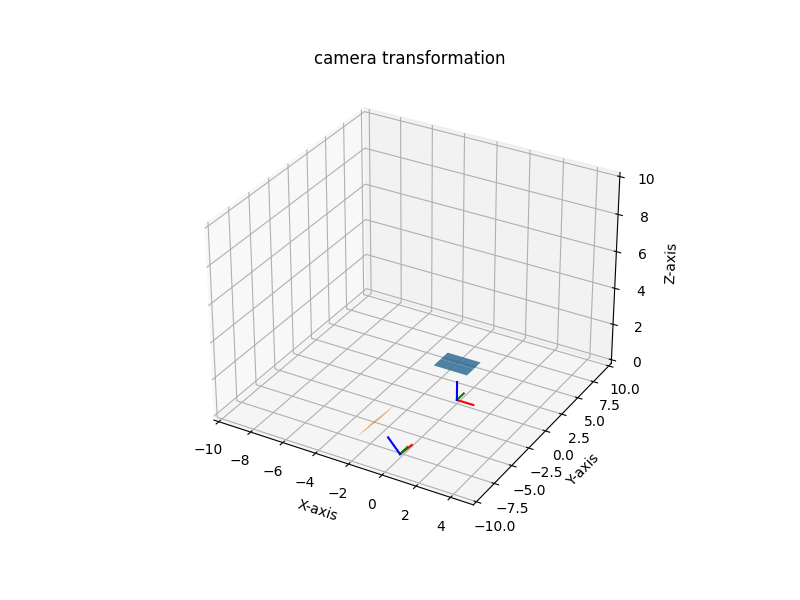

In [19]:
# define axis and figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111,projection='3d')

# set limits
ax.set(xlim=(-10, 5), ylim=(-10, 10), zlim=(0, 10))

# plot the global basis and the transformed camera basis
ax = pr.plot_basis(ax)
ax = pr.plot_basis(ax, R, T)

# plot the original and transformed image plane
ax.plot_surface(xx, yy, Z, alpha=0.75)
ax.plot_surface(xxt, yyt, Zt, alpha=0.75)

ax.set_title("camera transformation")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

## Create change of basis matrix

In [20]:
E = np.linalg.inv(R_ @ T_)

In [21]:
E

array([[ 0.70710678,  0.        ,  0.70710678,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  8.        ],
       [-0.70710678,  0.        ,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [22]:
# remove last row of E
E = E[:-1, :]

In [23]:
E

array([[ 0.70710678,  0.        ,  0.70710678,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  8.        ],
       [-0.70710678,  0.        ,  0.70710678,  0.        ]])

# Perform change of coordinates

In [24]:
cw = np.array([-1/np.sqrt(2), -8, 1/np.sqrt(2), 1]) # homogeneous coordinates of the point wrt the world

In [25]:
cw

array([-0.70710678, -8.        ,  0.70710678,  1.        ])

In [26]:
cc = E @ cw.reshape(4, 1) # coordinates of the point wrt the camera

In [27]:
cc

array([[-8.86511593e-17],
       [ 0.00000000e+00],
       [ 1.00000000e+00]])

In [28]:
cc = cc.flatten()

In [29]:
cc

array([-8.86511593e-17,  0.00000000e+00,  1.00000000e+00])